# **Convolutional Neural Network (CNN):**
A Convolutional Neural Network (CNN or ConvNet) is a type of deep neural network that is specifically designed to work with image data and excels when it comes to analyzing the images and making predictions on them.

It works with kernels (called filters) that go over the image and generates feature maps (that represent whether a certain feature is present at a location in the image or not) and initially it generates few feature maps and as we go deeper in the network the number of feature maps is increased and the size of maps is decreased using pooling operations without losing critical information.

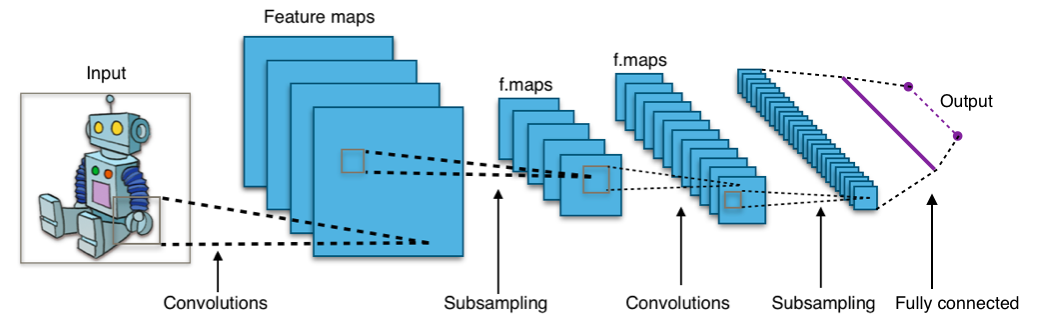

Each layer of a ConvNet learns features of increasing complexity which means, for example, the first layer may learn to detect edges and corners, while the last layer may learn to recognize humans in different postures.

# **Long Short Term Memory (LSTM):**

An LSTM network is specifically designed to work with a data sequence as it takes into consideration all of the previous inputs while generating an output. LSTMs are actually a type of neural network called Recurrent Neural Network, but RNNs are not known to be effective for dealing with the Long term dependencies in the input sequence because of a problem called the Vanishing gradient problem.
LSTMs were developed to overcome the vanishing gradient and so an LSTM cell can remember context for long input sequences.
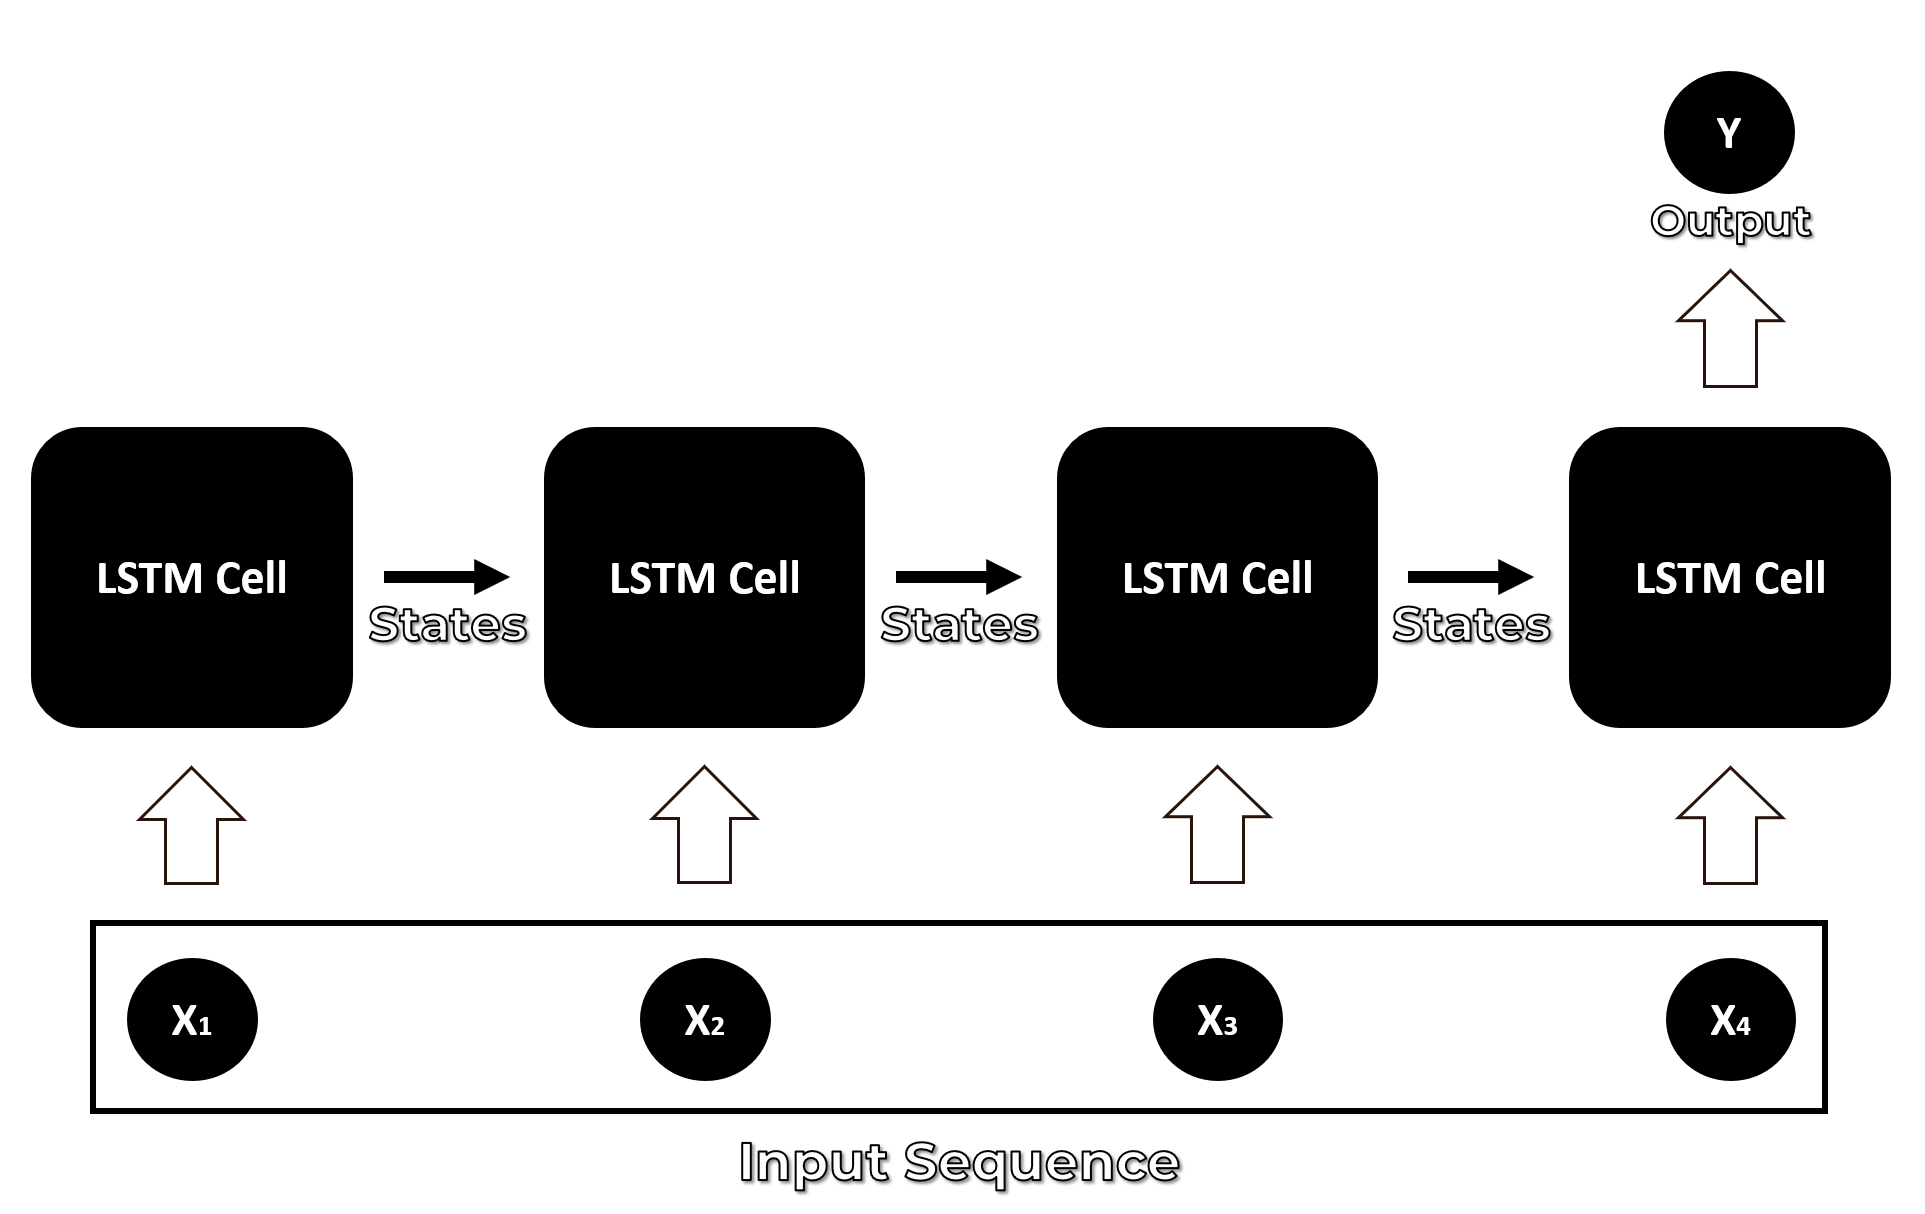

This makes an LSTM more capable of solving problems involving sequential data such as time series prediction, speech recognition, language translation, or music composition. But for now, we will only explore the role of LSTMs in developing better action recognition models.

Now let’s move on towards the approach we will implement in this tutorial to build an Action Recognizer. We will use a Convolution Neural Network (CNN) + Long Short Term Memory (LSTM) Network to perform Action Recognition while utilizing the Spatial-temporal aspect of the videos.


# **CNN + LSTM**

We will be using a CNN to extract spatial features at a given time step in the input sequence (video) and then an LSTM to identify temporal relations between frames.


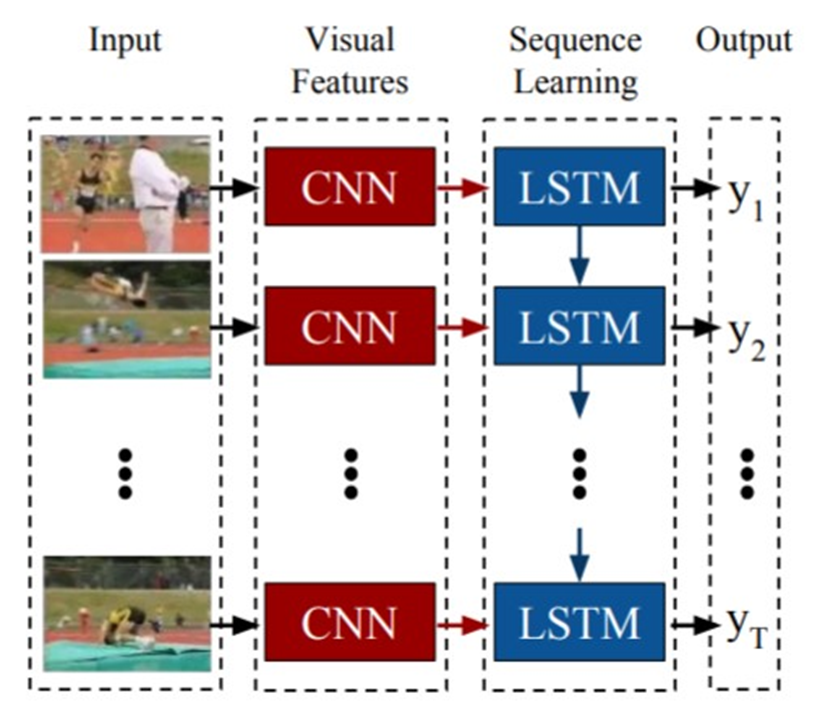


The two architectures that we will be using to use CNN along with LSTM are:


*   ConvLSTM
*   LRCN


Both of these approaches can be used using TensorFlow.

# **Import the Libraries**

In [1]:
# Install the required libraries.
!pip install pafy youtube-dl moviepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.5 MB/s eta 0:00:00


In [2]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt


from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

  if event.key is 'enter':



In [4]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

***Set Numpy, Python, and Tensorflow seeds to get consistent results on every execution.***

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# **Step 1: Download and Visualize the Data with its Labels**

In the first step, we downloaded and visualize the data along with labels to get an idea about what we will be dealing with. We are using the UCF50 – Action Recognition Dataset, consisting of realistic videos taken from youtube which differentiates this data set from most of the other available action recognition data sets as they are not realistic and are staged by actors. The Dataset contains:


*   50 Action Categories
*   25 Groups of Videos per Action Category
*   133 Average Videos per Action Category
*   199 Average Number of Frames per Video
*   320 Average Frames Width per Video
*   240 Average Frames Height per Video
*   26 Average Frames Per Seconds per Video
















In [5]:
# Discard the output of this cell.
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

For visualization, we picked 20 random categories from the dataset and a random video from each selected category and visualize the first frame of the selected videos with their associated labels written. This way we’ll be able to visualize a subset ( 20 random videos ) of the dataset.CodeText

In [6]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

# **Step 2: Preprocess the Dataset**

Next, we perform some preprocessing on the dataset. First, we read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range [0-1] by dividing the pixel values with 255, which makes convergence faster while training the network.

In [7]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [8]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

***Create a Function for Dataset Creation***

We create a function frames_extraction() that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames.

In [9]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Now we utilize the function create_dataset() created above to extract the data of the selected classes and create the required dataset.

In [10]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [11]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

# **Step 3: Split the Data into Train and Test Set**

As of now, we have the required features (a NumPy array containing all the extracted frames of the videos) and one_hot_encoded_labels (also a Numpy array containing all class labels in one hot encoded format). So now, we split our data to create training and testing sets. We also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [12]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

# **Step 4: Implement the ConvLSTM Approach**

In this step, we implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. it is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation.

***Step 4.1: Construct the Model***

To construct the model, we used Keras ConvLSTM2D recurrent layers. The ConvLSTM2D layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers is flattened in the end and is fed to the Dense layer with softmax activation which outputs the probability of each action category.

We also use MaxPooling3D layers to reduce the dimensions of the frames and avoid unnecessary computations and Dropout layers to prevent overfitting the model on the data. The architecture is a simple one and has a small number of trainable parameters. This is because we are only dealing with a small subset of the dataset which does not require a large-scale model.

In [13]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

Now we utilize the function create_convlstm_model() created above, to construct the required convlstm model.

In [14]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          11,524 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,524 (173.92 KB)

 Trainable params: 44,524 (173.92 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


**Check Model’s Structure:**

Now we use the plot_model() function, to check the structure of the constructed model, this is helpful while constructing a complex network and making that the network is created correctly.

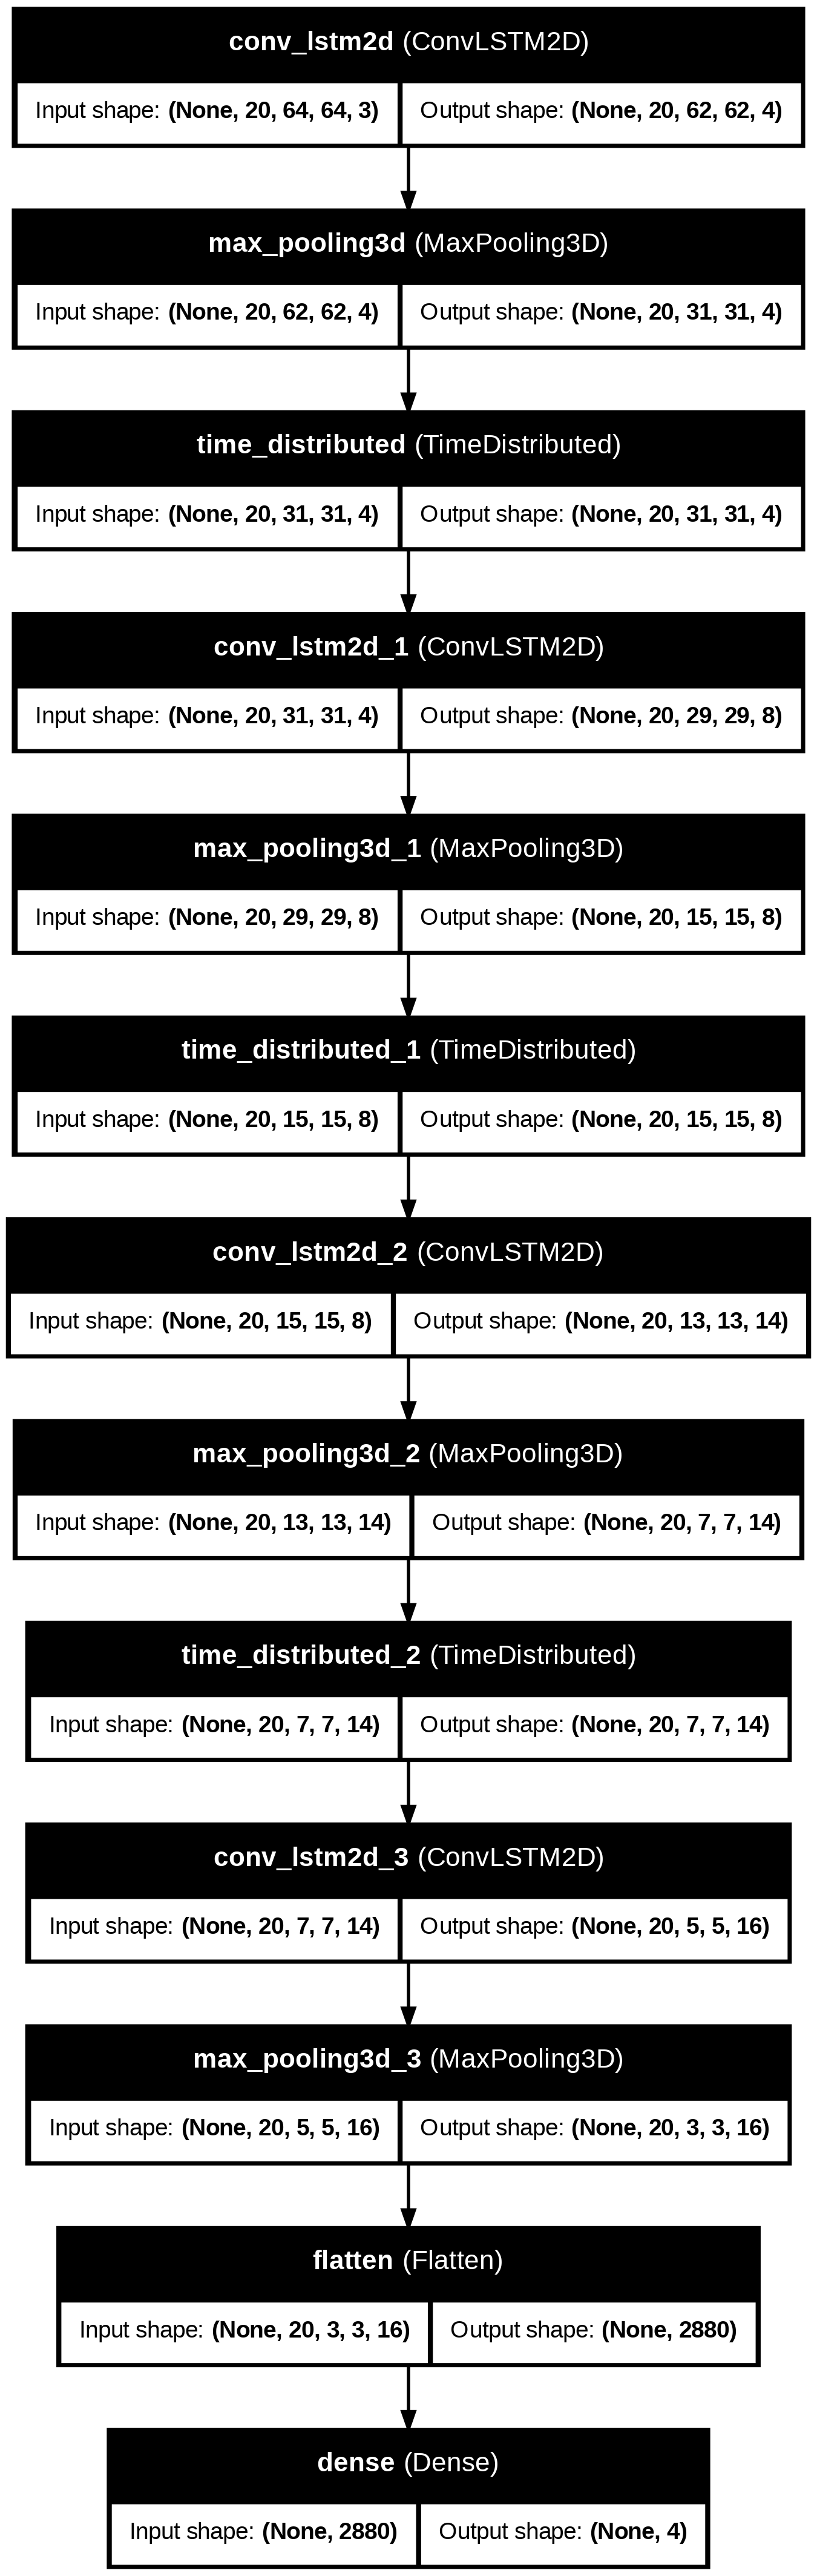

In [15]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

**Step 4.2: Compile & Train the Model**

Next, we will add an early stopping callback to prevent overfitting and start the training after compiling the model.

In [16]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.2574 - loss: 1.4029 - val_accuracy: 0.3562 - val_loss: 1.3793
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.2401 - loss: 1.3822 - val_accuracy: 0.3425 - val_loss: 1.3774
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.2965 - loss: 1.3711 - val_accuracy: 0.4658 - val_loss: 1.2515
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3728 - loss: 1.3328 - val_accuracy: 0.4795 - val_loss: 1.2075
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.4587 - loss: 1.2009 - val_accuracy: 0.5068 - val_loss: 1.1185
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.5024 - loss: 1.0582 - val_accuracy: 0.4795 - val_loss: 1.1931
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.5988 - loss: 0.9847 - val_accuracy: 0.5205 - val_loss: 1.0753
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.6518 - loss: 0.8386 - val_accuracy: 0.5753 - v

**Evaluate the Trained Model**

After training, we will evaluate the model on the test set.

In [17]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.6432 - loss: 0.7847


**Save the Model**

Now we will save the model to avoid training it from scratch every time we need the model.

In [18]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

**Step 4.3: Plot Model’s Loss & Accuracy Curves**

Now we create a function plot_metric() to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [19]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

Now we utilize the function plot_metric() created above, to visualize and understand the metrics.

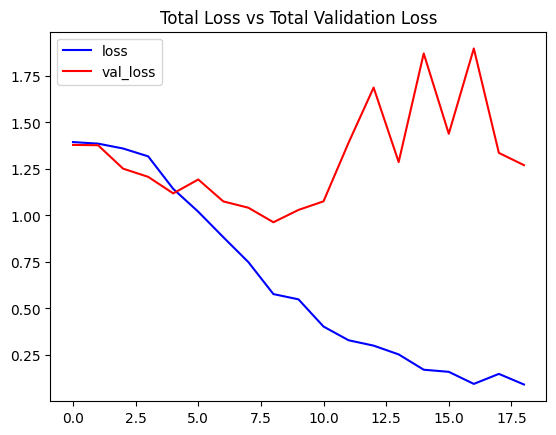

In [20]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

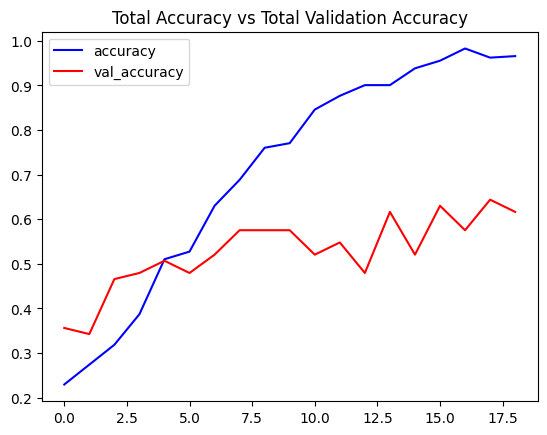

In [21]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# **Step 5: Implement the LRCN Approach**

In this step, we implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video.

But here, we implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

**Step 5.1: Construct the Model**

To implement our LRCN architecture, we use time-distributed Conv2D layers which will be followed by MaxPooling2D and Dropout layers. The feature extracted from the Conv2D layers will be then flattened using the Flatten layer and will be fed to a LSTM layer. The Dense layer with softmax activation will then use the output from the LSTM layer to predict the action being performed.

In [22]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

Now we utilize the function create_LRCN_model() created above to construct the required LRCN model.

In [23]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_3 (TimeDistributed) │ (None, 20, 64, 64, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 16, 16, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 20, 4, 4, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 20, 2, 2, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 20, 2, 2, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 20, 2, 2, 64)        │          36,928 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 20, 1, 1, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 20, 64)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


**Check Model’s Structure:**

Now we use the plot_model() function to check the structure of the constructed LRCN model. As we had checked for the previous model.

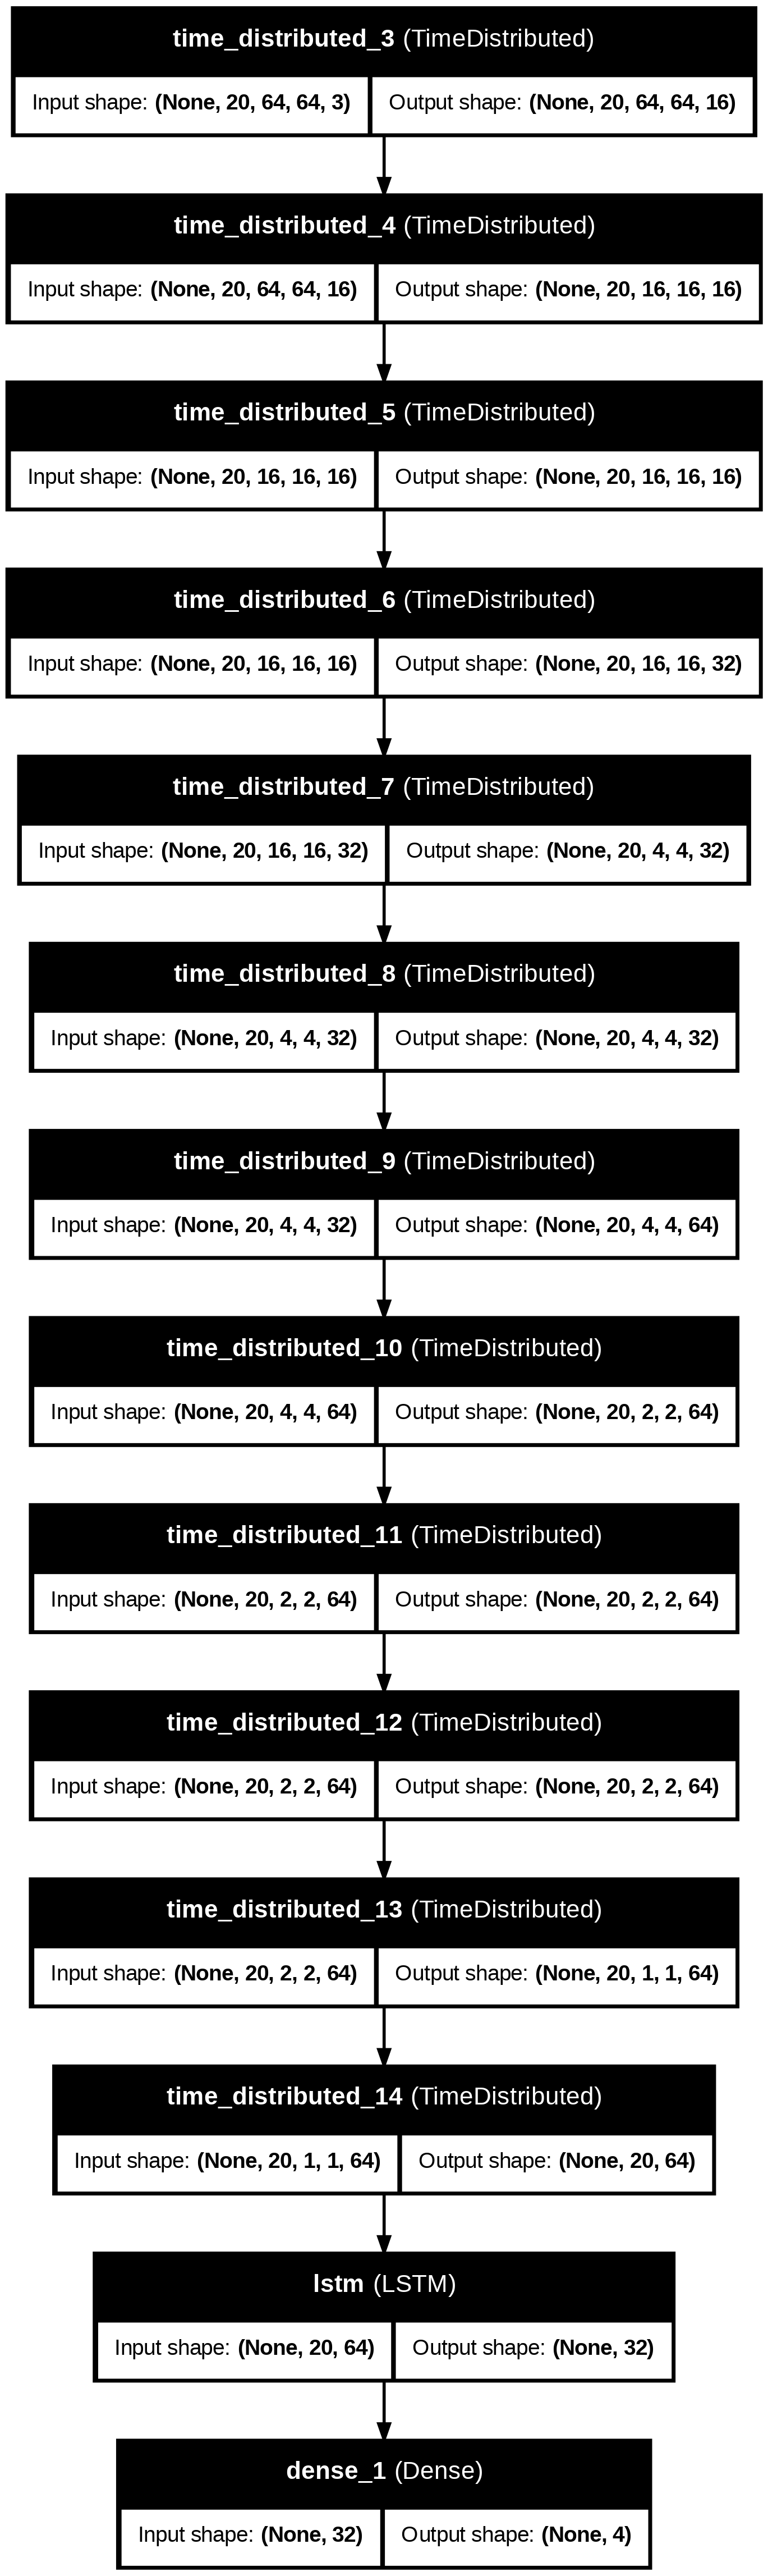

In [24]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

**Step 5.2: Compile & Train the Model**

After checking the structure, we compile and start training the model.

In [25]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 64s 619ms/step - accuracy: 0.2465 - loss: 1.4034 - val_accuracy: 0.3562 - val_loss: 1.3663
Epoch 2/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 81s 614ms/step - accuracy: 0.2764 - loss: 1.3705 - val_accuracy: 0.3836 - val_loss: 1.2574
Epoch 3/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 76s 530ms/step - accuracy: 0.4189 - loss: 1.3608 - val_accuracy: 0.4521 - val_loss: 1.1880
Epoch 4/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 44s 569ms/step - accuracy: 0.4978 - loss: 1.1764 - val_accuracy: 0.5068 - val_loss: 1.0938
Epoch 5/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 559ms/step - accuracy: 0.5714 - loss: 0.9311 - val_accuracy: 0.5342 - val_loss: 1.0633
Epoch 6/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 42s 575ms/step - accuracy: 0.6251 - loss: 0.8854 - val_accuracy: 0.4795 - val_loss: 1.2004
Epoch 7/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 556ms/step - accuracy: 0.6757 - loss: 0.7891 - val_accuracy: 0.5205 - val_loss: 1.0313
Epoch 8/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 42s 565ms/step - accuracy: 0.7646 - loss: 0.6280 - val_accu

**Evaluating the trained Model**

As done for the previous one, we evaluate the LRCN model on the test set.

In [26]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 0.8691 - loss: 0.4845


**Save the Model**

After that, we save the model for future uses using the same technique we had used for the previous model.

In [27]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

**Step 5.3: Plot Model’s Loss & Accuracy Curves**

Now we utilize the function plot_metric() we had created above to visualize the training and validation metrics of this model.

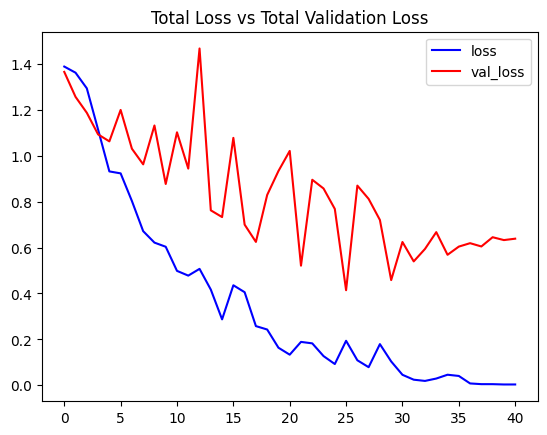

In [28]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

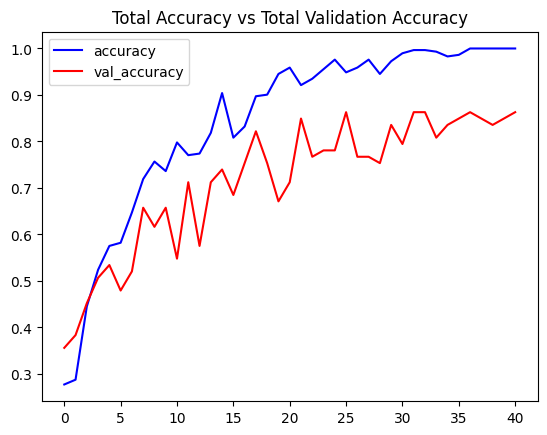

In [29]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# **Step 6: Test the Best Performing Model on YouTube videos**

From the results, it seems that the LRCN model performed significantly well for a small number of classes. so in this step, we put the LRCN model to test on some youtube videos.

**Create a Function to Download YouTube Videos:**

We create a function download_youtube_videos() to download the YouTube videos first using pafy library. The library only requires a URL to a video to download it along with its associated metadata like the title of the video.

In [30]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''

     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)

     # Retrieve the title of the video.
     title = video.title

     # Get the best available quality object for the video.
     video_best = video.getbest()

     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'

     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)

     # Return the video title.
     return title

**Download a Test Video:**

Now we utilize the function download_youtube_videos() created above to download a youtube video on which the LRCN model will be tested.

In [31]:
!pip install yt_dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.9/171.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 56.1 MB/s eta 0:00:00


In [32]:
import yt_dlp
import os

def download_youtube_videos(youtube_video_url, output_directory):
    """
    Downloads a YouTube video using yt-dlp and saves it to the specified directory.

    Args:
        youtube_video_url (str): URL of the video to download.
        output_directory (str): Directory where the video will be stored.

    Returns:
        str: The title of the downloaded YouTube video or an error message.
    """
    try:
        # Ensure the output directory exists
        os.makedirs(output_directory, exist_ok=True)

        # yt-dlp options to avoid 403 Forbidden error
        ydl_opts = {
            'outtmpl': f'{output_directory}/%(title)s.%(ext)s',  # Save as title.mp4
            'format': 'best',  # Fetch best available format
            'merge_output_format': 'mp4',  # Ensure output is MP4
            'http_headers': {'User-Agent': 'Mozilla/5.0'},  # Bypass bot detection
            'nocheckcertificate': True,  # Avoid SSL certificate issues
            'external_downloader': 'aria2c',  # Use aria2c for faster downloads
        }

        # Download video
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info_dict = ydl.extract_info(youtube_video_url, download=True)
            title = info_dict.get('title', 'Unknown Title')

        print(f"\n✅ Downloaded: {output_directory}/{title}.mp4")
        return title

    except Exception as e:
        print(f"\n❌ Error: {e}")
        return None

# Example Usage
test_videos_directory = "test_videos"
video_url = "https://www.youtube.com/watch?v=8u0qjmHIOcE"

video_title = download_youtube_videos(video_url, test_videos_directory)


[youtube] Extracting URL: https://www.youtube.com/watch?v=8u0qjmHIOcE
[youtube] 8u0qjmHIOcE: Downloading webpage
[youtube] 8u0qjmHIOcE: Downloading tv client config
[youtube] 8u0qjmHIOcE: Downloading player 6b3caec8
[youtube] 8u0qjmHIOcE: Downloading tv player API JSON
[youtube] 8u0qjmHIOcE: Downloading ios player API JSON
[youtube] 8u0qjmHIOcE: Downloading m3u8 information
[info] 8u0qjmHIOcE: Downloading 1 format(s): 18
[download] Destination: test_videos/Test Video.mp4
[download] 100% of    1.25MiB in 00:00:00 at 2.48MiB/s   

✅ Downloaded: test_videos/Test Video.mp4


In [33]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
# video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [ ]:
print(input_video_file_path)

test_videos/Test Video.mp4


In [ ]:
!pip uninstall youtube-dl
!pip install -U yt-dlp
!pip install -U youtube-dl pafy


Found existing installation: youtube-dl 2021.12.17
Uninstalling youtube-dl-2021.12.17:
  Would remove:
    /usr/local/bin/youtube-dl
    /usr/local/etc/bash_completion.d/youtube-dl.bash-completion
    /usr/local/etc/fish/completions/youtube-dl.fish
    /usr/local/lib/python3.11/dist-packages/youtube_dl-2021.12.17.dist-info/*
    /usr/local/lib/python3.11/dist-packages/youtube_dl/*
    /usr/local/share/doc/youtube_dl/README.txt
    /usr/local/share/man/man1/youtube-dl.1
Proceed (Y/n)? n
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.9/171.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 41.0 MB/s eta 0:00:00


**Create a Function To Perform Action Recognition on Videos**

Next, we create a function predict_on_video() that will simply read a video frame by frame from the path passed in as an argument and will perform action recognition on video and save the results.

In [34]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

**Perform Action Recognition on the Test Video**

Now we utilize the function predict_on_video() created above to perform action recognition on the test video we had downloaded using the function download_youtube_videos() and display the output video with the predicted action overlayed on it.

In [46]:
# Construct the output video path.
output_video_file_path = "/content/test_videos/Test Video-Output-SeqLen20.mp4"



# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

In [42]:
print(os.path.getsize(output_video_file_path))  # Should not be 0


2097196


In [47]:
!ffmpeg -i "/content/test_videos/Test Video-Output-SeqLen20.mp4"


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [49]:
!ffmpeg -i "/content/test_videos/Test Video-Output-SeqLen20.mp4" -c:v libx264 -preset slow -crf 23 -c:a aac -b:a 128k "/content/test_videos/Test Video-Output-SeqLen20.mp4"


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
print(output_video_file_path)

test_videos/Test Video-Output-SeqLen20.mp4


**Create a Function To Perform a Single Prediction on Videos**

Now let’s create a function that will perform a single prediction for the complete videos. We will extract evenly distributed N (SEQUENCE_LENGTH) frames from the entire video and pass them to the LRCN model. This approach is really useful when you are working with videos containing only one activity as it saves unnecessary computations and time in that scenario.

In [38]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Release the VideoCapture object.
    video_reader.release()

**Perform Single Prediction on a Test Video**

Now we utilize the function predict_single_action() created above to perform a single prediction on a complete youtube test video that we will download using the function download_youtube_videos(), we had created above.

In [ ]:
# Download the youtube video.
video_title = download_youtube_videos('https://youtu.be/fc3w827kwyA', test_videos_directory)

# Construct tihe nput youtube video path
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display(maxduration=300)  # 5 minutes
